In [ ]:
# Pandarallelの準備
from pandarallel import pandarallel
pandarallel.initialize()

In [1]:
'''
差分内容
- Nanに-1を代入
'''

'\n差分内容\n- Nanに-1を代入\n'

In [2]:
# main module
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

# import pandas_profiling as pdp
import seaborn as sns

import lightgbm as lgb

from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error

import datetime
import gc
import logging
import pickle
from pickle import load
import sys, os

# -------------------------------------独自モジュール-------------------------------------
sys.path.append('../src/') #モジュールが入っているディレクトリのパスを指定
import eda
import maprepro as mpre
import maprepro2 as mpre2
# import config
# from utils import setup_logger, ModelFactory
# -------------------------------------独自モジュール-------------------------------------

In [3]:
path = '../../input'
sample = pd.read_csv(f'{path}/sample_submission.csv')
store = pd.read_csv(f'{path}/store.csv')

test = pd.read_csv(f'{path}/test.csv',
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

train = pd.read_csv(f'{path}/train.csv',
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))


C:\Users\hayatotominaga\anaconda3\envs\rake4\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# テストのNaNレコードの処理
# testのOpenにNaNがあるがOpen=0とは限らないので、平日なら1,休日なら0に置換して
tmp1 = test.sort_values('Open')[:-11] # NaNじゃないやつ
tmp2 = test.sort_values('Open')[-11:] # NaNのやつ

tmp2['Open'] = np.where(tmp2['DayOfWeek'] < 5,1,0) # NaNをすべて置換完了
tmp3 = tmp2.loc[(tmp2['Open']==1)] # 上記のうち予測に使うやつ
tmp10000 = tmp2.loc[(tmp2['Open']!=1)] # 上記のうち予測に使わないが、最後にSales=0としてくっつけたいので更新されないであろう変数名で保管しておく

test = pd.concat([tmp1,tmp3],axis=0)

In [5]:
train = train.sort_values('Date')
test = test.sort_values('Date')

In [6]:
### Setting a variable to easily distinguish train (1) from submit (0) set
train['Set'] = 1
test['Set'] = 0
### Combine train and test set
frames = [train, test]
df = pd.concat(frames,axis=0)

In [7]:
'''dfに対する処理
- mk YMWD Dayofyear
- dateint
- Saleslog
- Saleslog - cliping
- 
'''
def mk_YMD_DOY(df):
    var_name = 'Date'
    df[var_name + 'Year'] = pd.Index(df[var_name]).year
    df[var_name + 'Month'] = pd.Index(df[var_name]).month
    df[var_name + 'Week'] = pd.Index(df[var_name]).week
    df[var_name + 'Day'] = pd.Index(df[var_name]).day
    df[var_name + 'DayOfYear'] = pd.Index(df[var_name]).dayofyear
    return df
df = mk_YMD_DOY(df)

df['DateInt'] = df['Date'].astype(np.int64)

<ipython-input-7-bb73e35c4ba3>:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df[var_name + 'Week'] = pd.Index(df[var_name]).week


In [8]:
# 目的変数の変換
df['Sales_log'] = np.log1p(df['Sales'])

In [9]:
# print(df.isnull().sum())
p01 = df.loc[(df['Set'] == 1)]['Sales_log'].quantile(0.01)
p09 = df.loc[(df['Set'] == 1)]['Sales_log'].quantile(0.9999)
df['Sales_log_clip'] = df['Sales_log'].clip(p01,p09)
# print('--'*80)
# print(df.isnull().sum())

In [10]:
'''
store処理
- PromoIntervalの処理
- dfと結合
'''
def processing_store(store):
    # --------------------------------- made promo 0,1,2,3 ---------------------------------

    s = store['PromoInterval'].str.split(',').apply(pd.Series,1)
    s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
    store = store.join(s)
    def monthToNum(date):
        return{
                'Jan' : 1,'Feb' : 2,'Mar' : 3,'Apr' : 4,'May' : 5,'Jun' : 6,'Jul' : 7,
                'Aug' : 8,'Sept' : 9, 'Oct' : 10,'Nov' : 11,'Dec' : 12
        }[date]

    store['PromoInterval0'] = store['PromoInterval0'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
    store['PromoInterval1'] = store['PromoInterval1'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
    store['PromoInterval2'] = store['PromoInterval2'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
    store['PromoInterval3'] = store['PromoInterval3'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)

    # --------------------------------- category to int(rabel encoding) ---------------------------------
    # intなので決定木系でないと使えない処理
    store['StoreType'] = store['StoreType'].astype('category').cat.codes
    store['Assortment'] = store['Assortment'].astype('category').cat.codes
    
    return store

store = processing_store(store)

use = ['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval0',
       'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
notuse_store = ['PromoInterval']
df = pd.merge(df, store[use], how='left', on=['Store'])

In [ ]:
# tmp = df.groupby(['Store','Y_M']).agg({'Sales':'mean'}).reset_index()

list_stores_to_check = [105,163,172,364,378,523,589,663,676,681,700,708,730,764,837,845,861,882,969,986]
# list_stores_to_check = list(range(1,30))

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # 月平均
#     X1 = tmp.loc[(tmp['Store'] == stor)]
#     y1 = tmp.loc[(tmp['Store'] == stor)]['Sales']

#     plt.subplot(len(list_stores_to_check),1,j)
#     plt.plot(X1['Y-M'], y1, '-')
#     plt.minorticks_on(); plt.grid(True, which='both') # whichがbothなので主目盛り副目盛り両方グリッド線を描画
#     plt.title(i)
    
    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]['Sales']
    
    plt.subplot(len(list_stores_to_check),1,j)
#     plt.plot(X1['Date'], y1, '-')
    plt.plot(X1['DateInt'], y1, '-')
    
    plt.minorticks_on(); plt.grid(True, which='both') # whichがbothなので主目盛り副目盛り両方グリッド線を描画
    plt.title(i)
    j += 1

In [11]:
store_dates_to_remove = {   105:1.368e18, 163:1.368e18,
                            172:1.366e18, 364:1.37e18,
                            378:1.39e18, 523:1.39e18,
                            589:1.37e18, 663:1.39e18,
                            676:1.366e18, 681:1.37e18,
                            700:1.373e18, 708:1.368e18,
                            709:1.423e18, 730:1.39e18,
                            764:1.368e18, 837:1.396e18,
                            845:1.368e18, 861:1.368e18,
                            882:1.368e18, 969:1.366e18,
                            986:1.368e18, 192:1.421e18,
                            263:1.421e18, 500:1.421e18,
                            797:1.421e18, 815:1.421e18,
                            825:1.421e18}

# for key,value in store_dates_to_remove.iteritems():
for key,value in store_dates_to_remove.items():
    df.loc[(df['Store'] == key) & (df['DateInt'] < value), 'Delete'] = True

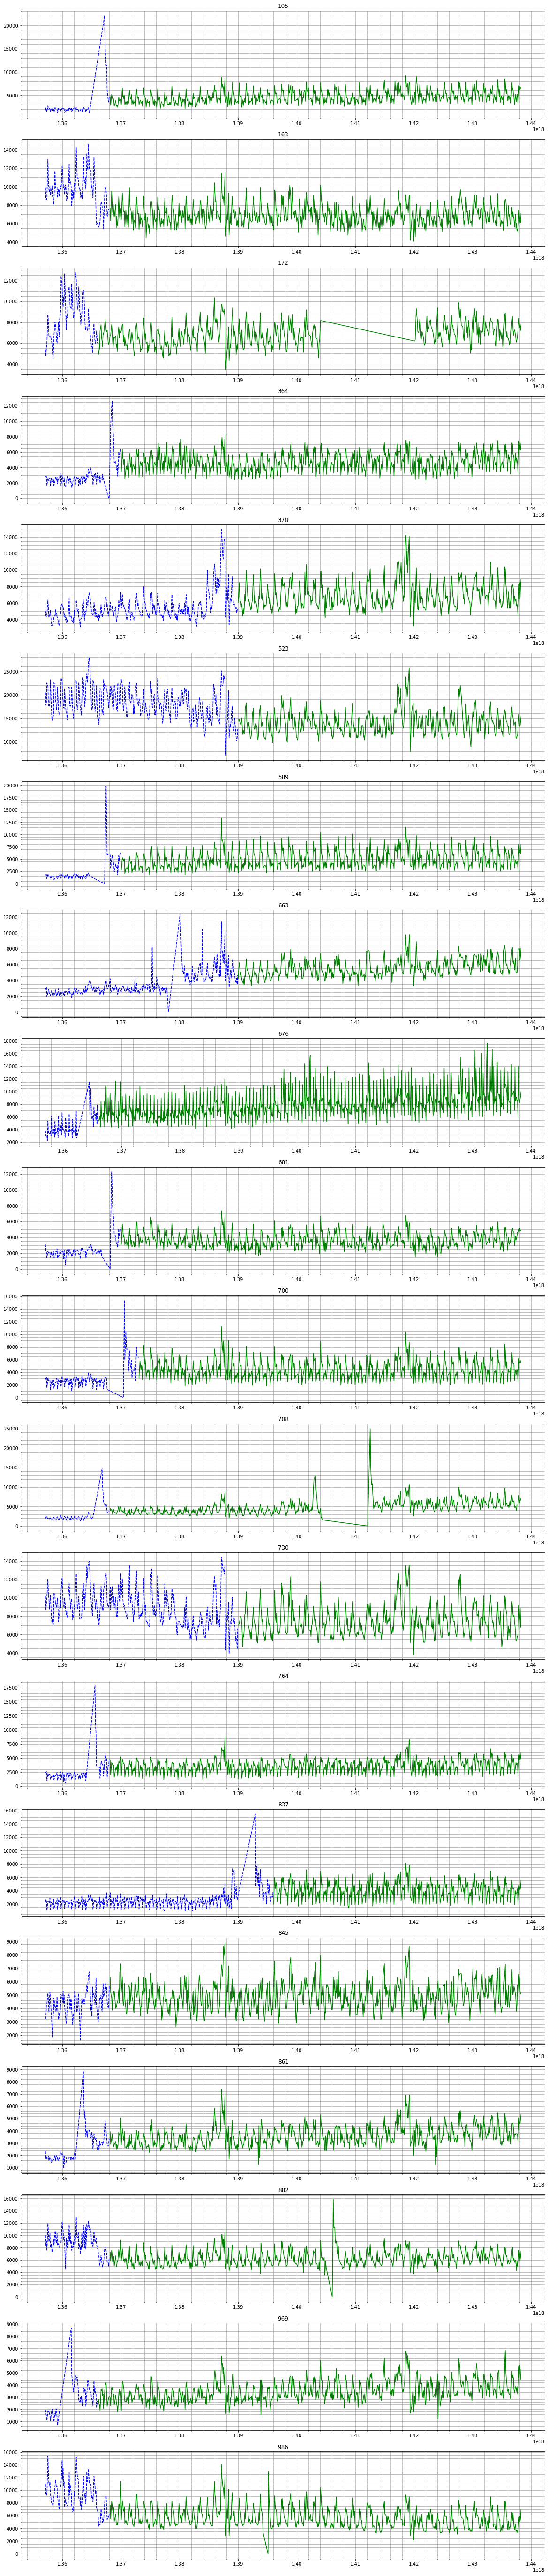

In [12]:
list_stores_to_check = [105,163,172,364,378,523,589,663,676,681,700,708,730,764,837,845,861,882,969,986]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] == True)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] == True)]['Sales']
    
    X2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] != True)]
    y2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] != True)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, 'b--') # 'r--o','r-o','r-'
    plt.plot(X2['DateInt'], y2, '-',color='g')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

In [13]:
# df.loc[(df['Set']==0) & (df['Delete'] == True)]
# df.loc[(df['Set']==0)].Delete.unique()

print(df.shape)
df = df.loc[df['Delete'] != True]
print(df.shape)
df = df.loc[(df['Open'] == 1)]
print(df.shape)

(1058294, 32)
(1050230, 32)
(873061, 32)


In [14]:
def mk_series_cv(df):
    df = df.sort_values('Date')
    # 時系列データであり、時間に沿って変数periodを設定したとする
    tmptr = df.loc[(df['Set'] == 1)]
    tmptr['period'] = np.arange(0, len(tmptr))// (len(tmptr)//4)
    tmptr['period'] = np.clip(tmptr['period'], 0, 3)

    tmpte = df.loc[(df['Set'] == 0)]
    tmpte['period'] = 4
    df = pd.concat([tmptr,tmpte],axis=0)
    return df

df = mk_series_cv(df)

<ipython-input-14-7dc2cd43dc52>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmptr['period'] = np.arange(0, len(tmptr))// (len(tmptr)//4)
<ipython-input-14-7dc2cd43dc52>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmptr['period'] = np.clip(tmptr['period'], 0, 3)
<ipython-input-14-7dc2cd43dc52>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [22]:
tmp = ['Promo2SinceWeek','Promo2SinceYear','PromoInterval0','PromoInterval1','PromoInterval2','PromoInterval3','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Customers','CompetitionDistance']
eda.miss_check(df[tmp])
# df.fillna(-1)

Your selected dataframe has 10 columns.
There are 10 columns that have missing values.


,Missing Values,% of Total Values
Promo2SinceWeek,435595,49.9
Promo2SinceYear,435595,49.9
PromoInterval0,435595,49.9
PromoInterval1,435595,49.9
PromoInterval2,435595,49.9
PromoInterval3,435595,49.9
CompetitionOpenSinceMonth,280819,32.2
CompetitionOpenSinceYear,280819,32.2
Customers,35101,4.0
CompetitionDistance,2259,0.3


In [14]:
df['StateHoliday'] = df.StateHoliday.astype('category')    
categorical_features = ['StateHoliday']

# alltmp = sorted(df.columns)
testid = ['Id']
target = ['Sales_log_clip']
# target = ['Sales','Sales_log']
notuse = ['Id','Date','Delete','Date','Y_M','Set','Sales']
use = ['Store','DayOfWeek','Open','Promo',
'StateHoliday','SchoolHoliday','DateYear','DateMonth','DateWeek','DateDay','DateDayOfYear',
'StoreType','Assortment','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
'Promo2','DateInt','period']

train_x = df.loc[(df['Set'] == 1)][use]
train_y = df.loc[(df['Set'] == 1)][target]
test = df.loc[(df['Set'] == 0)]
test = test.sort_values('Id').reset_index(drop=True)
test_x = test[use]
testid = test[testid]
testid = testid.Id.astype(np.int32)

In [142]:
import warnings
warnings.simplefilter('ignore')
train_x = eda.reduce_mem_usage(train_x)

start size(BEFORE): 111.08 Mb
Mem. usage decreased to 34.36 Mb (AFTER:69.1% reduction)


In [144]:
# --------------------------------------------------
import maprepro2 as mpre2
NOW,TMP_DIR = mpre2.mk_dir()
gc.collect()
# --------------------------------------------------

va_period_list = [1, 2, 3]
for va_period in va_period_list:
    print('i ================================================================== ',va_period)
    is_tr = train_x['period'] < va_period
    is_va = train_x['period'] == va_period
    tr_x, va_x = train_x[is_tr], train_x[is_va]
    tr_y, va_y = train_y[is_tr], train_y[is_va]
    
    lgb_train = lgb.Dataset(tr_x, tr_y)
    lgb_eval = lgb.Dataset(va_x, va_y)

    # ハイパーパラメータの設定
    params = {'objective': 'regression',
                'seed': 71,
                'verbose': 1,
                'metrics': 'rmse',
                'force_col_wise':'true' # メモリが足りないから
                }
    num_round = 100

    # 学習の実行
    categorical_features = categorical_features
    model = lgb.train(params, lgb_train, num_boost_round=num_round,
                    categorical_feature=categorical_features,
                    valid_names=['train', 'valid'], valid_sets=[lgb_train, lgb_eval],
                    )


    filename = f'{TMP_DIR}/trained_model{va_period}.pkl'
    pickle.dump(model, open(filename, 'wb'))

    # バリデーションデータでのスコアの確認
    va_pred = model.predict(va_x); va_pred = va_pred.reshape(-1, 1)

    # Open=0の日はすべてSalesが0で、0以外を予測することはありえないので0で更新(モデルは自然数を予測しているみたいだが、
    # Open=0ならSales=0をモデルに教えられていないということ)
#     tmp = va_x['Open'] == 0
#     va_pred[tmp]=0
    va_pred=va_pred+1; va_y=va_y+1

    # --------------------------------------------------
    # score = mean_squared_error(va_y, va_pred)
    RMSPE = np.sqrt(np.mean(((  (va_y-va_pred)/va_y)**2) )).values
    RMSPE = RMSPE.astype(float)[0] # printのために単一の数値にしたかった
    # score = log_loss(va_y, va_pred)
    print('RMSPE RMSPE RMSPE RMSPE RMSPE RMSPE: {:.4f}'.format(RMSPE))
    # --------------------------------------------------

#     del model # 学習済みモデルを削除


i ==================================================================  1
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 209490, number of used features: 16
[LightGBM] [Info] Start training from score 8.723874
[1]	train's rmse: 0.414639	valid's rmse: 0.421288
[2]	train's rmse: 0.404466	valid's rmse: 0.411986
[3]	train's rmse: 0.395699	valid's rmse: 0.403912
[4]	train's rmse: 0.388258	valid's rmse: 0.397151
[5]	train's rmse: 0.381885	valid's rmse: 0.3913
[6]	train's rmse: 0.376603	valid's rmse: 0.386538
[7]	train's rmse: 0.37208	valid's rmse: 0.382788
[8]	train's rmse: 0.367768	valid's rmse: 0.378707
[9]	train's rmse: 0.363932	valid's rmse: 0.37513
[10]	train's rmse: 0.360577	valid's rmse: 0.372261
[11]	train's rmse: 0.357605	valid's rmse: 0.369486
[12]	train's rmse: 0.354588	valid's rmse: 0.366731
[13]	train's rmse: 0.352064	valid's rmse: 0.364575
[14]	train's rmse: 0.34985	valid's rmse: 0.36263
[15]	train's rmse: 0.347284	valid's rmse: 0.3603

In [145]:
modeldict = mpre2.load_models(TMP_DIR)

load開始
load終わりました


In [146]:
pred_dict = mpre2.mk_pred_dict(modeldict,test_x)

予測リストが入った辞書作成開始
予測リストが入った辞書作成終了


In [147]:
# pred_wei_average = mpre2.wei_average(pred_dict,len(test_x))
# 重み付き平均がバグってたので算術平均で、変数名はそのままなので注意
pred_wei_average = (sum(pred_dict.values())/3)

In [148]:
pred_wei_average = np.expm1(pred_wei_average)
subpred = pd.DataFrame(pred_wei_average)
testid = testid.reset_index(drop=True)

sub = pd.concat([testid,subpred],axis=1)
sub.columns = ['Id','Sales']

In [149]:
tmptest = pd.read_csv(f'{path}/test.csv')
tmp9999 = tmptest.loc[(tmptest['Open']==0)]
'''
tmp9999 # Open=0のやつ
tmp10000 # Open=NaNのやつで、休日っぽいから冒頭でOpen=0に置換して保存しておいたやつ
'''
tmptest = pd.concat([tmp9999,tmp10000],axis=0)
tmptest = tmptest[['Id']]
tmptest['Sales']=0
tmptest
sub2 = pd.concat([tmptest,sub],axis=0)

In [150]:
mpre2.mk_output(df=sub2,NOW=NOW,PRACTICE=False)

PRACTICE=False
MADE ../../output/2021-08-05_20-48-37.csv


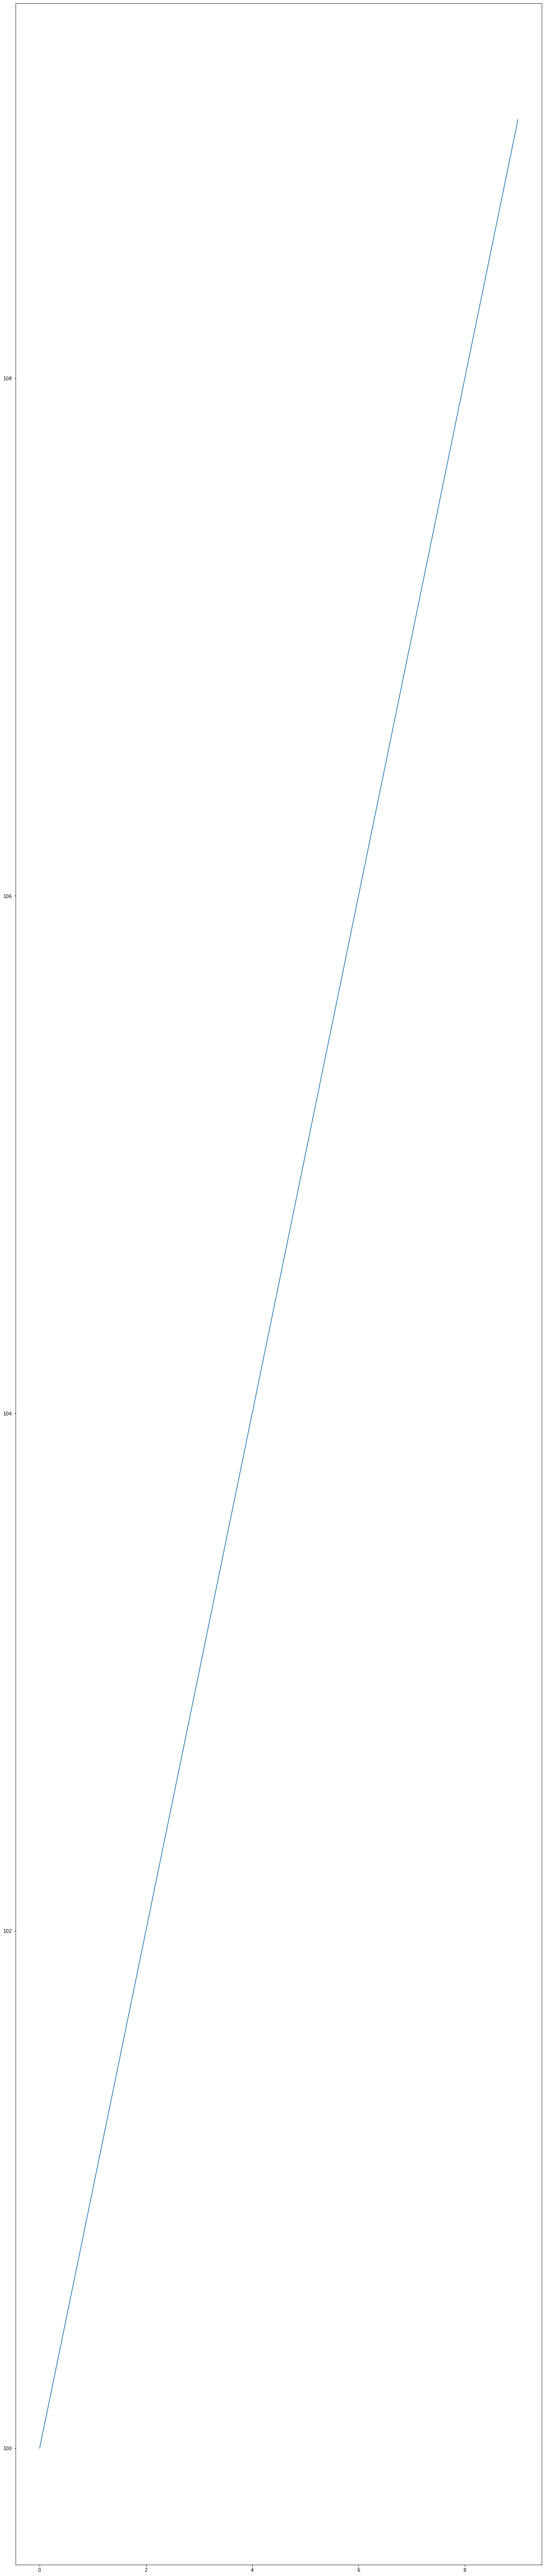

In [90]:
# fig, ax = plt.subplots()などの後にax.plotなどを使う流儀です。figやaxはこの記事で説明するArtistと呼ばれるオブジェクトの一種です。一番シンプルな例はこんな感じです。
x = range(0,10)
y = list(range(100,110))

fig, ax = plt.subplots()
ax.plot(x,y)

# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# ax.plot(x, y)

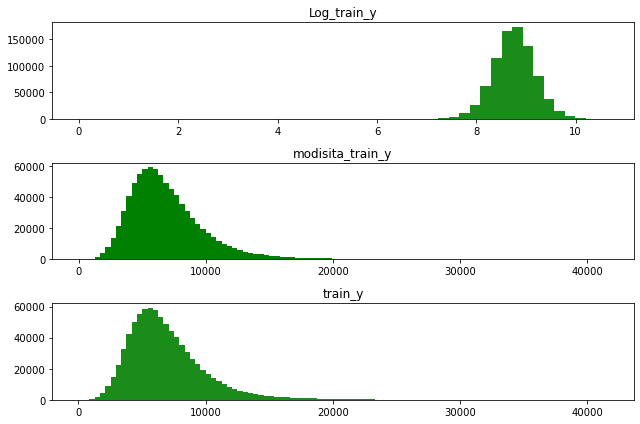

In [91]:
import matplotlib.pyplot as plt
fig1 = plt.figure(1,figsize=(9,6))

#1つ目のウィンドウ 1つ目のグラフ
ax1 = fig1.add_subplot(311)
# ax1.hist(np.expm1(train_y),bins=50, histtype='bar',color='g',alpha=0.9)
ax1.hist(df['Sales_log'],bins=50, histtype='bar',color='g',alpha=0.9)
ax1.set_title('Log_train_y')

#1つ目のウィンドウ 2つ目のグラフ
ax2 = fig1.add_subplot(312)
ax2.hist(np.expm1(df['Sales_log']),bins=100, histtype='bar',color='g')
# ax2.set_ylim( (-2,2) )
ax2.set_title('modisita_train_y')

#1つ目のウィンドウ 3つ目のグラフ
ax3 = fig1.add_subplot(313)
ax3.hist(train['Sales'][train['Sales']>0],bins=100, histtype='bar',color='g',alpha=0.9)
# ax2.set_ylim( (-2,2) )
ax3.set_title('train_y')

fig1.tight_layout()  # グラフの文字がかぶらないようにする


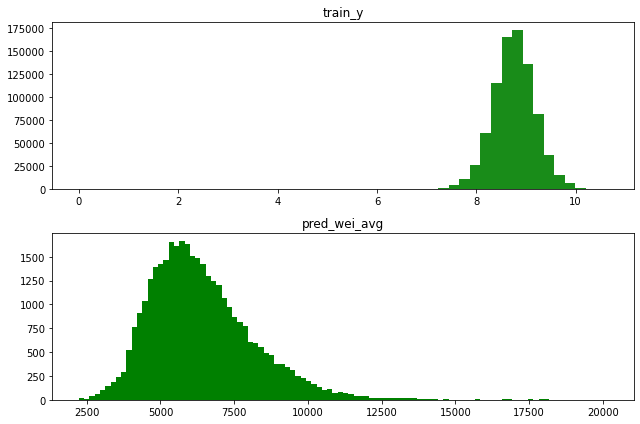

In [92]:
import matplotlib.pyplot as plt
fig1 = plt.figure(1,figsize=(9,6))
#1つ目のウィンドウ 1つ目のグラフ
ax1 = fig1.add_subplot(211)
# ax1.hist(np.expm1(train_y),bins=50, histtype='bar',color='g',alpha=0.9)
ax1.hist(train_y,bins=50, histtype='bar',color='g',alpha=0.9)
ax1.set_title('train_y')

#1つ目のウィンドウ 2つ目のグラフ
ax2 = fig1.add_subplot(212)
# ax2.hist(np.expm1(pred_wei_average),bins=100, histtype='bar',color='g')
ax2.hist(pred_wei_average,bins=100, histtype='bar',color='g')
# ax2.set_ylim( (-2,2) )
ax2.set_title('pred_wei_avg')

fig1.tight_layout()  # グラフの文字がかぶらないようにする


In [93]:
df['Sales_log']import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(20, 6))
# plt.hist(sub2.Sales,bins=50, histtype='bar',color='g',alpha=0.9)
# plt.hist(train.Sales,bins=50, histtype='bar',color='g',alpha=0.3)
# # sub2.Sales.plot.hist(ax=ax,figsize=(20, 6),bins=50, histtype='bar',color='g')
# # ax = fig.add_subplot(2, 1, 2)
# np.log1p(train.Sales).plot.hist(ax=ax,figsize=(20, 6),bins=100, histtype='bar',color='g')
# plt.show()

fig1 = plt.figure(1,figsize=(9,6))
#1つ目のウィンドウ 1つ目のグラフ
ax1 = fig1.add_subplot(211)
ax1.hist(sub2.Sales,bins=50, histtype='bar',color='g',alpha=0.9)
ax1.grid(True)
# # ax1.set_ylim( (-2,2) )
ax1.set_xlabel('Pred')
ax1.set_ylabel('Freq')
# ax1.set_title('sin function')

#1つ目のウィンドウ 2つ目のグラフ
ax2 = fig1.add_subplot(212)
ax2.hist(train.Sales,bins=100, histtype='bar',color='g')
ax2.grid(True)
# ax2.set_ylim( (-2,2) )
ax2.set_xlabel('train')
ax2.set_ylabel('Freq')
# ax2.set_title('cos function')

SyntaxError: invalid syntax (<ipython-input-93-5b65ee70b936>, line 1)

In [ ]:
fig1 = plt.figure(1,figsize=(9,6))
t = np.linspace(-1,1,1000)
#1つ目のウィンドウ 1つ目のグラフ
ax1 = fig1.add_subplot(211)
ax1.plot(t, np.sin(2*np.pi*t))
ax1.grid(True)
ax1.set_ylim( (-2,2) )
ax1.set_xlabel('t')
ax1.set_ylabel('f (t)')
ax1.set_title('sin function')

################################
#1つ目のウィンドウ 2つ目のグラフ
################################
ax2 = fig1.add_subplot(212)
ax2.plot(t, np.cos(2*np.pi*t))
ax2.grid(True)
ax2.set_ylim( (-2,2) )
ax2.set_xlabel('t')
ax2.set_ylabel('f (t)')
ax2.set_title('cos function')